# Access data from the ASReview file

<div class="alert alert-warning">

The API is still under development and can change at any time without warning. 

</div>

All data generated while using ASReview is stored in an ASReview project file. We look at how to get data out of this file, using the ASReview Python API. There are two ways to get data out of the project file. Via the state API and via the project API. The state API is for getting data related directly to the labeling actions, such as the labels, the time of labeling, the classifier used. The project API is for all other information, general settings, the dataset, the feature matrix, etc.



### Data used for this tutorial
We use the ASReview file `example.asreview`, which is the result of running a simulation on the `van_de_Schoot_2017` benchmark dataset using the command: ```asreview simulate benchmark:van_de_Schoot_2017 -s example.asreview```
Note that the original dataset contains 6189 records, but the simulation stopped after finding all relevant records, which in this case turned out to be after 547 records.

### Python Imports

In [1]:
import shutil
from pathlib import Path

import pandas as pd
from asreview import open_state
from asreview import ASReviewProject
from asreview import ASReviewData

## Getting data via the project API
The project file is a zipped folder containing several other files. To get dat via the project API we first need to unzip this folder in an empty temporary directory:

In [2]:
project_path = Path("tmp_data")
project_path.mkdir()
project = ASReviewProject.load('example.asreview', project_path)

Now we ready to read the data. For example, we can view the config file of the project.


In [3]:
project.config

{'version': '1.0rc1+46.gb310417.dirty',
 'id': 'example',
 'mode': 'simulate',
 'name': 'example',
 'description': 'Simulation created via ASReview via command line interface',
 'authors': None,
 'created_at_unix': 1654172382,
 'datetimeCreated': '2022-06-02 14:19:42.822517',
 'reviews': [{'id': '23a4a370cba1433db3842b20a504ec82',
   'start_time': '2022-06-02 14:19:43.214958',
   'status': 'finished',
   'end_time': '2022-06-02 14:19:51.587138'}],
 'feature_matrices': [{'id': 'tfidf', 'filename': 'tfidf_feature_matrix.npz'}],
 'dataset_path': 'van_de_Schoot_2017.csv'}

We can view the dataset that was used in the review. It is located at `/tmp_data/{project_name}/data/{dataset_filename}`.

In [4]:
dataset_fp = Path(project_path, project.config['id'], "data", project.config['dataset_path'])
dataset = ASReviewData.from_file(dataset_fp)
dataset.to_dataframe().head()

,title,abstract,keywords,authors,year,date,doi,label_included,label_abstract_screening,duplicate_record_id
record_id,,,,,,,,,,
0,Manual for ASEBA School-Age Forms & Profiles,,,"Achenbach, T. M., Rescorla, L. A.",2001.0,2001,NaN,0,0,NaN
1,Queensland Trauma Registry: A summary of paedi...,,,"Dallow, N., Lang, J., Bellamy, N.",2007.0,2007,NaN,0,0,NaN
2,Posttraumatic Stress Disorder: Scientific and ...,This comprehensive overview of research and cl...,,"Ford, J. D., Grasso, D. J., Elhai, J. D., Cour...",2015.0,NaN,NaN,0,0,NaN
3,SOCIAL CLASS AND MENTAL ILLNESS,,,"Hollingshead, A. B., Redlich, F. C.",1958.0,NaN,NaN,0,0,NaN
4,Computerised test generation for cross-nationa...,“‘Computerised Test Generation for Cross-Natio...,,"Irvine, S. H.",2014.0,NaN,NaN,0,0,NaN


We can also get the feature matrix that was generated from the dataset by the feature extractor. Let's print the first row, and note that the matrix is in a sparse matrix format.

In [5]:
feature_extraction_id = project.feature_matrices[0]['id']
feature_matrix = project.get_feature_matrix(feature_extraction_id)
print(feature_matrix[0])

  (0, 20452)	0.35937211648312967
  (0, 18297)	0.26158369118434677
  (0, 13842)	0.3248271421716685
  (0, 9739)	0.38355660008860293
  (0, 3231)	0.7059309068495663
  (0, 2384)	0.22684547910949254


## Getting data via the state API
(REF TO DOCS)
To get the complete table of data as a pandas DataFrame use:

In [6]:
with open_state('example.asreview') as state:
    df = state.get_dataset()
df.head()

,record_id,label,classifier,query_strategy,balance_strategy,feature_extraction,training_set,labeling_time,notes
0,2455,1,None,prior,None,None,-1,2022-06-02 14:19:45.069368,None
1,2677,0,None,prior,None,None,-1,2022-06-02 14:19:45.069368,None
2,2859,0,nb,max,double,tfidf,2,2022-06-02 14:19:45.163866,None
3,3406,0,nb,max,double,tfidf,3,2022-06-02 14:19:45.179505,None
4,1366,0,nb,max,double,tfidf,4,2022-06-02 14:19:45.195130,None


There are also multiple functions provided to directly get one specific type of data. For example, we can get the labeling times and plot them in a graph.

<AxesSubplot:title={'center':'Time of labeling'}>

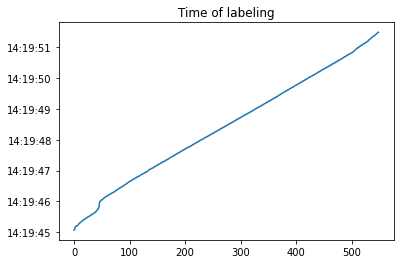

In [7]:
with open_state('example.asreview') as state:
    labeling_times = state.get_labeling_times()
pd.to_datetime(labeling_times).plot(title="Time of labeling")

See the documentation for the other available options. By default, the records that are part of the prior knowledge are included in the returned result. It is easy to exclude them from the result. For example these are the labels of all records after the prior knowledge:

In [8]:
with open_state('example.asreview') as state:
    labels = state.get_labels(priors=False)
labels

0      0
1      0
2      0
3      0
4      0
      ..
542    0
543    0
544    0
545    0
546    1
Name: label, Length: 547, dtype: int64

You can also get the data corresponding to a specific record identifier.

In [9]:
with open_state('example.asreview') as state:
    record_data = state.get_data_by_record_id(5176)
record_data

,record_id,label,classifier,query_strategy,balance_strategy,feature_extraction,training_set,labeling_time,notes
0,5176,0,nb,max,double,tfidf,5,2022-06-02 14:19:45.195130,None


### Cleanup
The following cell deletes the temporary folder that was created.

In [10]:
shutil.rmtree(project_path)